In [1]:
import sys; sys.path.insert(0, "../..");

In [2]:
%load_ext autoreload
%autoreload 2
import edunn as nn
import numpy as np

# Redes Neuronales Recurrentes

Las redes neuronales recurrentes (RNN) son un tipo de arquitectura especialmente diseñada para trabajar con datos secuenciales, como series temporales, texto o audio. A diferencia de una capa densa tradicional, una **capa RNN tiene memoria**: puede tomar en cuenta no solo la entrada actual, sino también lo que ha visto anteriormente, gracias a su mecanismo de retroalimentación.

Estas fueron una de las primeras arquitecturas capaces de modelar lenguaje de manera contextual, lo que las convierte en precursoras de los actuales modelos de lenguaje de gran escala (LLMs).

> Los archivos que se utilizaran en esta guía práctica serán: `edunn\models\cross_entropy_error.py` y `edunn\models\rnn.py`.

In [3]:
X_train, y_train, word_to_index, index_to_word = nn.datasets.load_sequence_generation("reddit_comments")

In [4]:
print("x example:", " ".join(index_to_word[x] for x in  X_train[0]))
print("x indices:",  X_train[0])
print("y example:", " ".join(index_to_word[y] for y in y_train[0]))
print("y indices:", y_train[0])

x example: <SOS> body "i joined a new league this year and they have different scoring rules than i'm used to
x indices: [3, 495, 85, 3624, 6, 141, 825, 22, 226, 7, 28, 18, 182, 5076, 452, 74, 59, 187, 5]
y example: body "i joined a new league this year and they have different scoring rules than i'm used to <EOS>
y indices: [495, 85, 3624, 6, 141, 825, 22, 226, 7, 28, 18, 182, 5076, 452, 74, 59, 187, 5, 2]


In [5]:
vocab_size = len(word_to_index)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 8000


In [6]:
index_to_word[0], index_to_word[1], index_to_word[2], index_to_word[3]

('<UNK>', '<PAD>', '<EOS>', '<SOS>')

In [7]:
X_train.shape, y_train.shape

((83080,), (83080,))

In [8]:
X_train = X_train[:1000]
y_train = y_train[:1000]

In [9]:
def pad_sequences(sequences, max_len=None, padding_value=0):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded = np.full((len(sequences), max_len), padding_value, dtype=np.int32)
    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq[:max_len]
    return padded

In [10]:
def encode_onehot(sequences, vocab_size, max_len):
    one_hot = np.zeros((len(sequences), max_len, vocab_size))
    for i, seq in enumerate(sequences):
        for t, idx in enumerate(seq):
            if idx < vocab_size:  # Evitar índices fuera de rango
                one_hot[i, t, idx] = 1
    return one_hot

In [11]:
max_len = 50  # Ajusta según tus datos
X_train_padded = pad_sequences(X_train, max_len=max_len, padding_value=1)
y_train_padded = pad_sequences(y_train, max_len=max_len, padding_value=1)

In [12]:
X_train_padded.shape, y_train_padded.shape

((1000, 50), (1000, 50))

In [13]:
X_train_onehot = encode_onehot(X_train_padded, vocab_size, max_len)
y_train_onehot = encode_onehot(y_train_padded, vocab_size, max_len)

In [14]:
X_train_onehot.shape, y_train_onehot.shape

((1000, 50, 8000), (1000, 50, 8000))

In [15]:
X_train[0], X_train_padded[0], X_train_onehot[0]

([3,
  495,
  85,
  3624,
  6,
  141,
  825,
  22,
  226,
  7,
  28,
  18,
  182,
  5076,
  452,
  74,
  59,
  187,
  5],
 array([   3,  495,   85, 3624,    6,  141,  825,   22,  226,    7,   28,
          18,  182, 5076,  452,   74,   59,  187,    5,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]))

## Método Forward

La arquitectura de una RNN se puede describir medianate la terna de parámetros $(\mathbf{U} \in \mathbb{R}^{H \times I}, \mathbf{W} \in \mathbb{R}^{H \times H}, \mathbf{V} \in \mathbb{R}^{O \times H})$, que son compartidos en las diferentes etapas de tiempo.

![alt text](img/rnn.png)

Las ecuaciones del forward pass son:

$$
\begin{aligned}
\mathbf{h}^{(t)} &= \tanh\left(\mathbf{x}^{(t)} \mathbf{U}^\top + \mathbf{h}^{(t-1)} \mathbf{W}^\top\right)
\\
\mathbf{y}^{(t)} &= \mathbf{h}^{(t)} \mathbf{V}^\top
\end{aligned}
$$

donde $\mathbf{x}^{(t)} \in \mathbb{R}^{B \times I}$ es la secuencia de entrada, $\mathbf{h}^{(t)} \in \mathbb{R}^{B \times H}$ es el **estado oculto**, e $\mathbf{y}^{(t)} \in \mathbb{R}^{B \times O}$ es la **salida**.

> $B$ es el tamaño del lote (`batch_size`), $I$ es la dimensión de entrada (`input_dim`), $H$ es la dimensión oculta (`hidden_dim`), y $O$ es la dimensión de salida (`output_dim`). Llamaremos $C$ al tamaño del vocabulario (`vocab_size`).

Existen variantes como [LSTM (Long Short-Term Memory)](https://ieeexplore.ieee.org/abstract/document/6795963) o [GRU (Gated Recurrent Unit)](https://arxiv.org/abs/1406.1078), que fueron diseñadas para **mitigar el problema del desvanecimiento del gradiente** que enfrentan las RNN tradicionales al modelar dependencias largas. Ambas introducen puertas (*gates*) que regulan el flujo de información a través del tiempo. LSTM lo hace mediante tres puertas (input, forget, output), mientras que GRU simplifica la arquitectura utilizando solo dos (update y reset).

## Método Backward

<div style="background-color: black; text-align: center;">
<img src="img/rnn-bptt-with-gradients.png" width=75%>
</div>

Sabiendo que para un tiempo $t$ fijo, el $i$-ésimo componente de $\mathbf{y}^{(t)}$ y que el gradiente de la función de error $E$ con respecto a dicha salida está dado por ($\in\mathbb{R}^{B\times O}$):

$$
y^{(t)}_i = \sum_{k=1}^{H} h^{(t)}_k V_{ik},
\quad
\mathbf{g}^{(t)}\equiv \frac{\partial E}{\partial \mathbf{y}^{(t)}}
$$

> La **delta de Kronecker** $\delta_{ki}$ es una forma compacta y elegante de expresar la condición: la expresión vale solo si dos índices son iguales.
>$$
\underbrace{
\frac{\partial}{\partial B_{ij}} \left( \sum_{n=1}^{N} a_n B_{kn} \right)
}_{\mathclap{\text{= } a_j \text{ si y solo si } k = i}}
=
\begin{cases}
a_j & \text{si } k = i, \\
0 & \text{si } k \ne i.
\end{cases}
= a_j \cdot \delta_{ki}
>$$

### `dE_dV`

$$
\frac{\partial E}{\partial \mathbf{V}} = \sum_{t=0}^{T-1} \frac{\partial E}{\partial \mathbf{y}^{(t)}} \frac{\partial \mathbf{y}^{(t)}}{\partial \mathbf{V}}
$$

Entonces, por la regla de la cadena:

$$
\frac{\partial E}{\partial V_{ik}}
= \sum_{j=1}^{O} \frac{\partial E}{\partial y^{(t)}_j} \frac{\partial y^{(t)}_j}{\partial V_{ik}}
= \sum_{j=1}^{O} g^{(t)}_j \underbrace{ \frac{\partial}{\partial V_{ik}} \left( \sum_{k=1}^{H} h^{(t)}_k V_{jk} \right) }_{\mathclap{h^{(t)}_k \delta_{ij}}}
= g^{(t)}_i h^{(t)}_k
$$

Es decir, cada entrada del gradiente es un producto "exterior" entre el vector de errores en salida y el estado oculto, sumando sobre todos los pasos temporales:

$$
\boxed{\quad
\frac{\partial E}{\partial \mathbf{V}}
= \sum_{t=0}^{T-1} \left( \frac{\partial E}{\partial \mathbf{y}^{(t)}} \right)^{\top} \mathbf{h}^{(t)}
= \sum_{t=0}^{T-1} \left( \mathbf{g}^{(t)}\right)^{\top} \mathbf{h}^{(t)} \in\mathbb{R}^{O\times H}
\quad}
$$

<!-- dE_dV += dE_dy[:, t, :].T @ h[:, t, :] -->

### `dE_dU`

$$
\frac{\partial E}{\partial \mathbf{U}} = \sum_{t=0}^{T-1} \frac{\partial E}{\partial \mathbf{y}^{(t)}} \frac{\partial \mathbf{y}^{(t)}}{\partial \mathbf{U}}
$$

Entonces, por la regla de la cadena:

$$
\frac{\partial y^{(t)}_i}{\partial U_{pq}} = \sum_{k=1}^{H} V_{ik} \frac{\partial h^{(t)}_k}{\partial U_{pq}}
$$

Definimos a la "entrada no activada":

$$
\mathbf{a}^{(t)} = \mathbf{x}^{(t)} \mathbf{U}^{\top} + \mathbf{h}^{(t-1)} \mathbf{W}^{\top}
\quad \Longrightarrow \quad
a^{(t)}_k = \sum_{m=1}^{I} x^{(t)}_m U_{km} + \sum_{r=1}^{H} h^{(t-1)}_r W_{kr}
$$

Como $h^{(t)}_k = \tanh(a^{(t)}_k)$, y por definición $\tfrac{d\tanh(f(x))}{dx} := \left( 1 - \tanh^{2}(f(x))\right) \cdot \tfrac{df(x)}{dx}$, entonces:

$$
\frac{\partial h^{(t)}_k}{\partial U_{pq}}
= \left( 1-(h^{(t)}_k)^{2}\right) \frac{\partial a^{(t)}_k}{\partial U_{pq}}
$$

$$
\frac{\partial a^{(t)}_k}{\partial U_{pq}}
= \frac{\partial}{\partial U_{pq}} \left( \sum_{m=1}^{I} x^{(t)}_m U_{km} \right)
= x^{(t)}_q \delta_{kp}
$$

Por lo tanto:

$$
\frac{\partial y^{(t)}_i}{\partial U_{pq}}
= \sum_{k=0}^{H} V_{ik} \left( 1-(h^{(t)}_k)^{2}\right) x^{(t)}_q \delta_{kp}
= V_{ip} \left( 1-(h^{(t)}_p)^{2}\right) x^{(t)}_q
$$

Reemplazando en la expresión original:

$$
\frac{\partial E}{\partial U_{pq}}
= \sum_{t=0}^{T-1}\sum_{i=1}^{O} \underbrace{\frac{\partial E}{\partial y^{(t)}_i}}_{g^{(t)}_i} \frac{\partial y^{(t)}_i}{\partial U_{pq}}
= \sum_{t=0}^{T-1}\sum_{i=1}^{O} g^{(t)}_i V_{ip} \left( 1-(h^{(t)}_p)^{2}\right) x^{(t)}_q
$$

Definiendo ahora los "errores" intermedios (filas):

$$
\underbrace{\delta_h^{(t)}}_{\in\mathbb{R}^{B\times H}} := \mathbf{g}^{(t)}\mathbf{V}
\qquad\text{y}\qquad
\underbrace{\delta_a^{(t)}}_{\in\mathbb{R}^{B\times H}} := \delta_h^{(t)} \odot \left( 1-(\mathbf{h}^{(t)})^{2}\right)
$$

<!-- dE_dh = dE_dy[:, t, :] @ V + dh_next
dh_raw = (1 - h[:, t, :] ** 2) * dE_dh -->

Entonces $\sum_i g^{(t)}_i V_{ip} = (\delta_h^{(t)})_p$, y

$$
\frac{\partial E}{\partial U_{pq}}
= \sum_{t=0}^{T-1} \underbrace{\left( \delta_h^{(t)} \odot (1-(\mathbf{h}^{(t)})^{2})\right)_p}_{(\delta_a^{(t)})_p} x^{(t)}_q
$$

En forma matricial compacta (para cada $t$):

$$
\boxed{\quad
\frac{\partial E}{\partial \mathbf{U}}
= \sum_{t=0}^{T-1} \left( \frac{\partial E}{\partial \mathbf{y}^{(t)}} \mathbf{V}\right) \odot \left( 1-(\mathbf{h}^{(t)})^{2}\right)^{\top} \mathbf{x}^{(t)}
= \sum_{t=0}^{T-1} \left( \delta_a^{(t)}\right)^{\top} \mathbf{x}^{(t)} \in\mathbb{R}^{H\times I}
\quad}
$$

$\delta_a^{(t)}$ es exactamente el "producto exterior" **(error en preactivación)** × **(entrada actual)**.

<!-- dE_dU += dh_raw.T @ x[:, t, :] -->

### `dE_dW`

$$
\frac{\partial E}{\partial \mathbf{W}}
= \sum_{t=0}^{T-1}\frac{\partial E}{\partial \mathbf{y}^{(t)}} \frac{\partial \mathbf{y}^{(t)}}{\partial \mathbf{W}}
$$

Entonces, por la regla de la cadena:

$$
\frac{\partial y^{(t)}_i}{\partial W_{pr}}
= \sum_{k=0}^{H} V_{ik} \frac{\partial h^{(t)}_k}{\partial W_{pr}}
$$

Utilizando la misma definición de $\mathbf{a}^{(t)}$ (por $\tanh$) y manteniendo constante a $\mathbf{h}^{(t-1)}$ en el jacobiano local:

$$
\frac{\partial h^{(t)}_k}{\partial W_{pr}}
= \left( 1-(h^{(t)}_k)^{2}\right) \frac{\partial a^{(t)}_k}{\partial W_{pr}}
$$

$$
\frac{\partial a^{(t)}_k}{\partial W_{pr}}
= \frac{\partial}{\partial W_{pr}} \left( \sum_{l=1}^{H} h^{(t-1)}_l W_{kl} \right)
= h^{(t-1)}_{r} \delta_{kp}
$$

Por lo tanto:

$$
\frac{\partial y^{(t)}_i}{\partial W_{pr}}
= \sum_k V_{ik} \left( 1-(h^{(t)}_k)^{2}\right) h^{(t-1)}_{r} \delta_{kp}
= V_{ip} \left( 1-(h^{(t)}_p)^{2}\right) h^{(t-1)}_{r}
$$

Reemplazando en la expresión original:

$$
\frac{\partial E}{\partial W_{pr}}
= \sum_{t=0}^{T-1}\sum_{i=1}^{O} \underbrace{\frac{\partial E}{\partial y^{(t)}_i}}_{g^{(t)}_i} \frac{\partial y^{(t)}_i}{\partial W_{pr}}
= \sum_{t=0}^{T-1}\sum_{i=1}^{O} g^{(t)}_i V_{ip} \left( 1-(h^{(t)}_p)^{2}\right) h^{(t-1)}_{r}
$$

Utilizando las mismas definiciones anteriores de $\delta_h^{(t)}$ y $\delta_a^{(t)}$, entonces $\sum_i g^{(t)}_i V_{ip} = (\delta_h^{(t)})_p$ y:

$$
\boxed{\quad
\frac{\partial E}{\partial \mathbf{W}}
= \sum_{t=0}^{T-1} \left( \frac{\partial E}{\partial \mathbf{y}^{(t)}} \mathbf{V}\right) \odot \left( 1-(\mathbf{h}^{(t)})^{2}\right)^{\top} \mathbf{h}^{(t-1)}
= \sum_{t=0}^{T-1} \left( \delta_a^{(t)}\right)^{\top} \mathbf{h}^{(t-1)} \in\mathbb{R}^{H\times H}
\quad}
$$

(para $t=0$ el término vale cero ya que $ \mathbf{h}^{(-1)} = \mathbf{0}$, debido a que la actualización de los pesos de $\mathbf{W}$ depende del estado anterior, y como en el primer paso de tiempo no existe un estado oculto anterior, no hay contribución al gradiente de $\mathbf{W}$ en $t=0$).

<!-- if t > 0:
    dE_dW += dh_raw.T @ h[:, t-1, :] -->

### `dE_dx`

$$
\frac{\partial E}{\partial \mathbf{x}^{(t)}}
= \frac{\partial E}{\partial \mathbf{y}^{(t)}} \frac{\partial \mathbf{y}^{(t)}}{\partial \mathbf{x}^{(t)}}
$$

Entonces, por la regla de la cadena:

$$
\frac{\partial y^{(t)}_i}{\partial x^{(t)}_q}
= \sum_k V_{ik} \frac{\partial h^{(t)}_k}{\partial x^{(t)}_q}
$$

Utilizando la misma definición de $\mathbf{a}^{(t)}$ (por $\tanh$):

$$
\frac{\partial h^{(t)}_k}{\partial x^{(t)}_q}
= \left( 1-(h^{(t)}_k)^{2}\right) \frac{\partial a^{(t)}_k}{\partial x^{(t)}_q}
$$

$$
\frac{\partial a^{(t)}_k}{\partial x^{(t)}_q}
= \frac{\partial}{\partial x^{(t)}_q} \left( \sum_{m=1}^{I} x^{(t)}_m U_{km} \right)
= U_{kq}
$$

Por lo tanto:

$$
\frac{\partial y^{(t)}_i}{\partial x^{(t)}_q}
= \sum_{k=1}^{H} V_{ik} \left( 1-(h^{(t)}_k)^{2}\right) U_{kq}
$$

Reemplazando en la expresión original:

$$
\frac{\partial E}{\partial x^{(t)}_q}
= \sum_{i=1}^{O} \underbrace{\frac{\partial E}{\partial y^{(t)}_i}}_{g^{(t)}_i} \frac{\partial y^{(t)}_i}{\partial x^{(t)}_q}
= \sum_{i=1}^{O} \sum_{k=1}^{H} g^{(t)}_i V_{ik} \left( 1-(h^{(t)}_k)^{2}\right) U_{kq}
$$

Utilizando las mismas definiciones anteriores de $\delta_h^{(t)}$ y $\delta_a^{(t)}$, entonces $\sum_i g^{(t)}_i V_{ip} = (\delta_h^{(t)})_p$ y:

$$
\boxed{\quad
\frac{\partial E}{\partial \mathbf{x}^{(t)}}
= \left( \frac{\partial E}{\partial \mathbf{y}^{(t)}} \mathbf{V}\right) \odot \left( 1-(\mathbf{h}^{(t)})^{2}\right) \mathbf{U}
= \delta_a^{(t)} \mathbf{U} \in\mathbb{R}^{B\times I}
\quad}
$$

<!-- dE_dx[:, t, :] = dh_raw @ U -->

### `dE_dh`

Actualmente, los cálculos se hicieron solo con la contribución **directa**, pero para que exista una dependencia a través del tiempo, se deben contabilizar automáticamente las rutas por las que $\mathbf{U}$ y $\mathbf{W}$ afectan $\mathbf{h}^{(t-1)},\mathbf{h}^{(t-2)},\ldots$, acumulando gradientes (eso es, justamente, BPTT).

En el error total $E = \sum_s E^{(s)}$, $\mathbf{x}^{(t)}$ también afecta salidas futuras ($s>t$) vía $\mathbf{h}^{(t)} \to \mathbf{h}^{(t+1)} \to \cdots$. En la práctica, eso queda incorporado en $\delta_a^{(t)}$ porque se calcula con la recurrencia hacia atrás (sumando el "flujo futuro").

Al término $\delta_h^{(t)}$ hay que sumarle $\boldsymbol{\phi}^{(t)}$ que corresponde a la contribución **futura** (del estado anterior) del gradiente sobre $\mathbf{h}^{(t)}$ para que se vea afectado por ella el término $\delta_a^{(t)}$.

$$
\frac{\partial E}{\partial \mathbf{h}^{(t)}}
= \underbrace{\frac{\partial E^{(t)}}{\partial \mathbf{h}^{(t)}}}_{\text{aporte local}}
+ \underbrace{\sum_{s>t}\frac{\partial E^{(s)}}{\partial \mathbf{h}^{(t)}}}_{\text{aporte futuro}}
$$

<center>

| Aporte local (vía $\mathbf{y}^{(t)}$) | Aporte futuro (vía $\mathbf{h}^{(t)} \to \mathbf{h}^{(t+1)} \to \cdots$) con el primer eslabón $t \to t+1$: |
|:---------:|:---------:|
| $$ \frac{\partial E^{(t)}}{\partial \mathbf{h}^{(t)}} = \frac{\partial E^{(t)}}{\partial \mathbf{y}^{(t)}} \frac{\partial \mathbf{y}^{(t)}}{\partial \mathbf{h}^{(t)}} = \mathbf{g}^{(t)} \mathbf{V} $$ | $$ \sum_{s>t}\frac{\partial E^{(s)}}{\partial \mathbf{h}^{(t)}} = \frac{\partial E}{\partial \mathbf{h}^{(t+1)}} \frac{\partial \mathbf{h}^{(t+1)}}{\partial \mathbf{h}^{(t)}} = \frac{\partial E}{\partial \mathbf{h}^{(t+1)}} \underbrace{\frac{\partial \mathbf{h}^{(t+1)}}{\partial \mathbf{a}^{(t+1)}}}_{\text{diag}\left( 1-(\mathbf{h}^{(t+1)})^{2}\right)} \underbrace{\frac{\partial \mathbf{a}^{(t+1)}}{\partial \mathbf{h}^{(t)}}}_{\mathbf{W}} = \underbrace{\left( \frac{\partial E}{\partial \mathbf{h}^{(t+1)}} \odot (1-(\mathbf{h}^{(t+1)})^{2})\right)}_{\boldsymbol{\delta}_a^{(t+1)}} \mathbf{W} $$ |

</center>

<!-- #### Aporte local (vía $\mathbf{y}^{(t)}$)

$$
\frac{\partial E^{(t)}}{\partial \mathbf{h}^{(t)}}
= \frac{\partial E^{(t)}}{\partial \mathbf{y}^{(t)}}\frac{\partial \mathbf{y}^{(t)}}{\partial \mathbf{h}^{(t)}}
= \mathbf{g}^{(t)} \mathbf{V}
$$

#### Aporte futuro (vía $\mathbf{h}^{(t)} \to \mathbf{h}^{(t+1)} \to \cdots$)

El primer eslabón es $t \to t+1$:

$$
\sum_{s>t}\frac{\partial E^{(s)}}{\partial \mathbf{h}^{(t)}}
= \frac{\partial E}{\partial \mathbf{h}^{(t+1)}} \frac{\partial \mathbf{h}^{(t+1)}}{\partial \mathbf{h}^{(t)}}
= \frac{\partial E}{\partial \mathbf{h}^{(t+1)}}
\underbrace{\frac{\partial \mathbf{h}^{(t+1)}}{\partial \mathbf{a}^{(t+1)}}}_{\text{diag}\left( 1-(\mathbf{h}^{(t+1)})^{2}\right)}
\underbrace{\frac{\partial \mathbf{a}^{(t+1)}}{\partial \mathbf{h}^{(t)}}}_{\mathbf{W}}
= \underbrace{\left( \frac{\partial E}{\partial \mathbf{h}^{(t+1)}} \odot (1-(\mathbf{h}^{(t+1)})^{2})\right)}_{\boldsymbol{\delta}_a^{(t+1)}} \mathbf{W}
$$

#### Recurrencia final que inyecta $\boldsymbol{\phi}^{(t)}$ -->

La recurrencia final que inyecta $\boldsymbol{\phi}^{(t)}$ es:

$$
\boxed{\quad
\frac{\partial E}{\partial \mathbf{h}^{(t)}}
= \mathbf{g}^{(t)} \mathbf{V} + \underbrace{\boldsymbol{\delta}_a^{(t+1)} \mathbf{W}}_{\boldsymbol{\phi}^{(t)}} \in\mathbb{R}^{B\times H}
\quad}
$$

donde definimos $\delta_h^{(t)} \equiv \tfrac{\partial E}{\partial \mathbf{h}^{(t)}}$. En el borde $t=T-1$, no hay futuro, así que el flujo $\boldsymbol{\phi}^{(t)} = 0$, no hay estado anterior al que propagar el gradiente.

<!-- if t > 0:
    dh_next = dh_raw @ W
else:
    dh_next = 0  # No hay estado anterior para t=0 -->


## Implementación

En una RNN sin vectorizar todos los saltos de tiempo, se debe recorrer la secuencia paso a paso, de modo que el **`forward`** tendrá un bucle **ascendente**, ya que cada nuevo estado oculto $\mathbf{h}^{(t)}$ depende del estado anterior $\mathbf{h}^{(t-1)}$, y como se propaga la información de izquierda a derecha, es decir generamos $\mathbf{h}^{(0)}, \mathbf{h}^{(1)}, \mathbf{h}^{(2)},\dots$ en secuencia, el rango del for debe ser en orden cronológico: `for t in range(timesteps)`. 

```python
for t in range(timesteps):
    h_t = tanh(x_t·Uᵀ + h_(t−1)·Wᵀ)
    y_t = h_t·Vᵀ
    h_(t-1) = h_t
```

En cambio, **backpropagation through time (BPTT)**, como se deben acumular las derivadas de cada paso sobre los parámetros compartidos `(U, W, V)` y propagar el error hacia atrás en la secuencia, el gradiente en $\mathbf{h}^{(t-1)}$ recibe contribuciones de la propia pérdida en el paso $t-1$ y la retroalimentación (a través de $\mathbf{W}$) de la corrección en $\mathbf{h}^{(t)}$. Para respetar esta dependencia, el **`backward`** deberá comenzar en el último paso $T$ y avanzar de manera **descendente** $0$, acumulando el gradiente "hacia atrás" en el tiempo.

```python
for t in reversed(range(timesteps)):
    # gradientes de V, U, W, dx y propagación de dh
```

## Inicialización

La inicialización de los parámetros `(U, W, V)` es llamativamente importante para esta arquitectura. No se pueden inicializar todos de manera uniforme, ya que esto resultaría en un cálculo simétrico en todas las capas. Varios trabajos, como el de [Xavier Glorot](https://proceedings.mlr.press/v9/glorot10a), han presentado el impacto en los resultados de realizar una correcta inicialización de parámetros previo al entrenamiento. En este caso, tales pesos deben ser inicializados de manera aleatoria, donde la inicialización depende de la función de activación `tanh`, por lo que el enfoque recomendado es inicializarlos con el inicializador `XavierUniform`.

También, existe un problema en las RNN llamado el *vanishing gradient problem* que ocurre cuando los gradientes tienden a 0. Por eso, las RNN tradicionales no pueden capturar dependencias a largo plazo, así que usamos el parámetro `bptt_truncate` para limitar la longitud de la dependencia.


In [16]:
from edunn.initializers import XavierUniform
hidden_dim = 128
model = nn.RNN(vocab_size, vocab_size, hidden_dim, kernel_initializer=XavierUniform())

## Sequence Cross Entropy

En cada paso de tiempo $t$, en la salida $\mathbf{y}^{(t)}$, puede aplicarse una $\text{softmax}$, por lo que se podrá utilizar la pérdida de **entropía cruzada** junto la optimización por **descenso de gradiente** o similar, pero teniendo en cuenta algunas consideraciones.

$$E_{t}(\mathbf{y}^{(t)},\hat{\mathbf{y}}^{(t)}) =-\mathbf{y}^{(t)}\log\hat{\mathbf{y}}^{(t)} \quad \Rightarrow \quad E(\mathbf{y},\hat{\mathbf{y}})=\sum^{T-1}_{t=0}E_{t}(\mathbf{y}^{(t)},\hat{\mathbf{y}}^{(t)}) = -\sum^{T-1}_{t=0}\mathbf{y}^{(t)}\log\hat{\mathbf{y}}^{(t)}$$

Aquí, $\mathbf{y}^{(t)}$ representa la palabra correcta en el paso de tiempo $t$, e $\hat{\mathbf{y}}^{(t)}$ es nuestra predicción. Normalmente tratamos la secuencia completa (la frase) como un solo ejemplo de entrenamiento, así que el error total es simplemente la suma de los errores en cada paso de tiempo (cada palabra).

### Método Forward

La RNN devuelve un vector $\hat{\mathbf{y}}$ con logits de tamaño `(batch_size, timesteps, vocab_size)`, que para que podamos utilizar la función de pérdida de entropía cruzada, estos deben pasar por una $\text{softmax}$ para transformarlos en una distribución de probaiblidad y así poder compararlos con la etiqueta correcta $\mathbf{y}$ (representada en one-hot).

$$
E_{t}\bigl(\mathbf{y}^{(t)},\,\hat{\mathbf{y}}^{(t)}\bigr)
\;=\;
-\sum_{c=1}^{C}y^{(t)}_{c}\,\log \bigl(\text{softmax}(\hat{\mathbf{y}}^{(t)})_{c}\bigr)

\quad
\Rightarrow
\quad

E(\mathbf{y},\hat{\mathbf{y}})
\;=\;
\sum_{t=0}^{T-1}E_{t}\bigl(\mathbf{y}^{(t)},\,\hat{\mathbf{y}}^{(t)}\bigr)
\;=\;
-\,\sum_{t=0}^{T-1}\sum_{c=1}^{C}y^{(t)}_{c}\,\log \bigl(\text{softmax}(\hat{\mathbf{y}}^{(t)})_{c}\bigr)
$$

> NOTA: se deben ignorar los tokens de padding (aquellos que sólo rellenan hasta la longitud fija) y normalizar sobre el número de tokens válidos.

#### Implementación

Se define la **máscara de tokens válidos** como $\mathrm{mask}_{b,t} = \mathbb{1}_{\mathrm{token}_{b,t} \neq \text{padding}} \in \{0,1\}^{B\times T}$. Luego convertimos el vector de logits $\hat{\mathbf{y}}^{(b,t)}\in\mathbb{R}^{C}$ en probabilidades $\mathbf{p}^{(b,t)} = \text{softmax}(\hat{\mathbf{y}}^{(b,t)})\in[0,1]^{C}$. En consecuencia calculamos $E_{b,t} = - \sum_{c} \mathbf{y}^{(b,t)}_{c} \log p^{(b,t)}_{c}$ para seleccionar las **probabilidades verdaderas**, ya que $c$ es el token correcto en $(b,t)$.

Finalmente, sumamos sobre todos los $(b,t)$, ignorando padding al multiplicar por la máscara, y dividimos por la suma de la máscara ya que tal suma representa una media por token, de modo que la magnitud de la pérdida sea comparable independientemente de cuántos pasos de tiempo tenga cada batch.

$$
\boxed{\quad
E =  \frac{1}{\sum_{b,t}\mathrm{mask}_{b,t}} \sum_{b=1}^{B}\sum_{t=0}^{T-1} E_{b,t}                                                  \mathrm{mask}_{b,t}
  = -\frac{1}{\sum_{b,t}\mathrm{mask}_{b,t}} \sum_{b=1}^{B}\sum_{t=0}^{T-1} \sum_{c=1}^{C} \mathbf{y}^{(b,t)}_{c} \log p^{(b,t)}_{c} \mathrm{mask}_{b,t}
\quad}
$$

> La función $\text{softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$ puede generar valores muy pequeños o muy grandes si los $z_i$ (*logits*) tienen magnitudes altas o muy dispares. Esto puede llevar a **overflow** o **underflow** numérico en la computación. En cambio, $\log\text{softmax}(\mathbf{z})_i = z_i - \log\sum_j e^{z_j}$ permite restar el log-sum-exp **antes** de exponenciar, lo que estabiliza y evita errores numéricos.
>
> Además, **por razones de estabilidad numérica**, se resta el máximo en la `log_softmax`, ya que la parte crítica $\sum_j e^{z_j}$ es sensible a que si algún $z_j$ es muy grande, $e^{z_j}$ tendrá valor `inf`:
>
> $$
> \textstyle
> \log\text{softmax}(\mathbf{z})_i = z_i - \log\sum_j e^{z_j}
> \quad \longrightarrow \quad
> z_i - z_{\text{max}} - \log\sum_j e^{z_j - z_{\text{max}}}
> $$

### Método Backward

La derivada de la entropía cruzada combinada con softmax para un vector de logits $\hat{\mathbf{y}}^{(b,t)}\in\mathbb{R}^{C}$ y vector de etiqueta $\mathbf{y}^{(b,t)}\in\{0,1\}^{C}$ one-hot se calcula:

$$
\frac{\partial E}{\partial \hat{\mathbf{y}}^{(b,t)}} = \frac{\partial E}{\partial \mathbf{p}^{(b,t)}} \frac{\partial \mathbf{p}^{(b,t)}}{\partial \hat{\mathbf{y}}^{(b,t)}}
$$

> Usamos que $\dfrac{\partial}{\partial \hat z_j}\log p_i = \frac{1}{p_i}\frac{\partial p_i}{\partial \hat z_j}$ y el jacobiano de softmax es $\dfrac{\partial p_i}{\partial z_j} = p_i (\delta_{ij} - p_j)$.


### `dp_dŷ`

Fijemos un par $(b,t)$ y derivemos respecto del logit $\hat y^{(b,t)}_j$:

$$
\frac{\partial p^{(b,t)}_c}{\partial \hat y^{(b,t)}_j}
= p^{(b,t)}_c (\delta_{cj} - p^{(b,t)}_j)
$$

### `dE_dp`

Fijemos un par $(b,t)$ y derivemos respecto del logit $\hat y^{(b,t)}_j$:

$$
\frac{\partial}{\partial \hat y^{(b,t)}_j}\big(\log p^{(b,t)}_c\big)
= \frac{1}{p^{(b,t)}_c} \cdot p^{(b,t)}_c (\delta_{cj} - p^{(b,t)}_j) = \delta_{cj} - p^{(b,t)}_j
$$

y por tanto

$$
\frac{\partial E}{\partial \hat y^{(b,t)}_j}
= -\frac{\mathrm{mask}_{b,t}}{\sum_{b',t'}\mathrm{mask}_{b',t'}} \sum_{c=1}^C y^{(b,t)}_c \frac{\partial}{\partial \hat y^{(b,t)}_j}\big(\log p^{(b,t)}_c\big)
= -\frac{\mathrm{mask}_{b,t}}{\sum_{b',t'}\mathrm{mask}_{b',t'}} \sum_{c=1}^C y^{(b,t)}_c (\delta_{cj}-p^{(b,t)}_j)
= -\frac{\mathrm{mask}_{b,t}}{\sum_{b',t'}\mathrm{mask}_{b',t'}} \big(y^{(b,t)}_j - p^{(b,t)}_j\big).
$$

Reordenando signos y en forma vectorial para ese $(b,t)$:

$$
\boxed{\quad
\frac{\partial E}{\partial \hat{\mathbf y}^{(b,t)}}
= \frac{\mathrm{mask}_{b,t}}{\sum_{b',t'}\mathrm{mask}_{b',t'}} \big(\mathbf p^{(b,t)} - \mathbf y^{(b,t)}\big)
\quad}
$$


#### Implementación

Se reconstruyen las probabilidades $\mathbf{p}^{(b,t)}\in[0,1]^{C}$ y definimos al gradiente inicial en el espacio $\mathbb{R}^{B\times T\times C}$ como $g^{(b,t)}_{c} = p^{(b,t)}_{c} - y^{(b,t)}_{c}$, finalmente aplicamos la máscara y normalizamos nuevamente a nivel de tokens de la secuencia, como se realizó en el forward pass.

$$
\frac{\partial E}{\partial \hat{\mathbf{y}}^{(b,t)}} = \mathbf{g}^{(b,t)} \odot \frac{\mathrm{mask}_{b,t}}{\sum_{b',t'}\mathrm{mask}_{b',t'}}
$$

y para todo el lote/tiempo, la misma expresión aplica elemento a elemento (broadcasting de la máscara con `mask[:,:,None]`).

In [17]:
error = nn.SequenceCrossEntropyWithLabels(pad_index=1)
optimizer = nn.GradientDescent(lr=0.1, epochs=100, batch_size=16)

In [18]:
# history = optimizer.optimize(model, X_train_onehot, y_train_onehot, error)
# nn.plot.plot_history(history, error_name=error.name)

In [19]:
y_pred = model.forward(X_train_onehot[:1])
y_pred_labels = nn.utils.onehot2labels(y_pred)

In [20]:
y_pred.shape, y_pred_labels.shape

((1, 50, 8000), (1, 8000))

In [21]:
decode_greedy = lambda seq, eos=2: list(seq)[:list(seq).index(eos)] if eos in seq else list(seq)

In [22]:
print("X:", " ".join(index_to_word[x] for x in X_train[0]))
print("y:", " ".join(index_to_word[y] for y in y_train[0]))
print("ŷ:", " ".join(index_to_word[y] for y in decode_greedy(y_pred_labels[0])))

X: <SOS> body "i joined a new league this year and they have different scoring rules than i'm used to
y: body "i joined a new league this year and they have different scoring rules than i'm used to <EOS>
ŷ: but " have was you and that like in this to for and with people for it get on was not <PAD> it on on but as my people so people is what that have " for if with it have is is more and what but for for and " of a on your you more with and on with with with it but " a get and your a people was but that don't of that have i that have a was the on in if i an the get but people <PAD> with this of but or are if with people for people for is it and can this in on if from people on with get " for i don't be not don't and have but be


# Copy Task

El dataset anterior, `reddit_comments`, es similar a una tarea clásica de clasificación binaria conocida como "copy-task" (o, de forma más informal, "echo-task"). Esta tarea es ideal para verificar la lógica de memoria temporal mediante salidas codificadas en one-hot. Sin embargo, dado que ese dataset tiene un `vocab_size=8000`, entrenar una RNN con él requiere muchas épocas y una cantidad considerable de datos.

La tarea consiste en presentar una secuencia seguida por un período de *silencio* (padding), y luego solicitar al modelo que **reproduzca** la secuencia original.

Para facilitar un entrenamiento controlado, puede generarse automáticamente un dataset en el que se cumpla `X[t] == X[t-k]`, es decir, el modelo debe predecir el símbolo que ocurrió `k` pasos atrás. Esta tarea secuencia-a-secuencia con enteros permite verificar que la RNN aprende dependencias temporales, ya que obliga a la red a **memorizar** o **retener** información durante múltiples pasos. Así se puede comprobar que el estado oculto y el algoritmo de retropropagación a través del tiempo (BPTT) están funcionando correctamente.

> Si tu red **aprende a repetir** el token correcto con una pérdida baja, significa que la BPTT, la gestión del estado y el cálculo de gradientes están bien implementados.  
> Si no lo logra, sabrás que el fallo está en la parte recurrente o en la propagación temporal, y no en la complejidad del lenguaje natural.


In [23]:
def generate_echo_dataset(vocab_size: int,
                          seq_len: int,
                          delay: int,
                          num_sequences: int):
    """
    Generates a toy 'echo' dataset.

    Args:
        vocab_size (int): Size of the vocabulary, including PAD token at index 0.
        seq_len (int): Length of each sequence.
        delay (int): How many steps to delay the echo (target output).
        num_sequences (int): Number of sequences to generate.

    Returns:
        tuple[np.ndarray, np.ndarray]: A pair of arrays (X_onehot, Y_onehot),
        both with shape (num_sequences, seq_len, vocab_size).
    """

    X_int = np.random.randint(1, vocab_size, size=(num_sequences, seq_len))
    Y_int = np.zeros_like(X_int) # los primeros `delay` son PAD
    Y_int[:, delay:] = X_int[:, :-delay]

    X_onehot = np.eye(vocab_size)[X_int]
    Y_onehot = np.eye(vocab_size)[Y_int]
    
    return X_onehot, Y_onehot

In [24]:
vocab_size   = 51    # 0=PAD, 1..50 símbolos reales
seq_len      = 20
delay        = 3
num_sequences = 2048

X_echo, Y_echo = generate_echo_dataset(vocab_size, seq_len, delay, num_sequences)

print("X_int ejemplo:", np.argmax(X_echo[0], axis=1))
print("Y_int ejemplo:", np.argmax(Y_echo[0], axis=1))

X_int ejemplo: [47 31  6 18 28  8 17 50 22 25 31 22 19 31 23  5 47 44 34 32]
Y_int ejemplo: [ 0  0  0 47 31  6 18 28  8 17 50 22 25 31 22 19 31 23  5 47]


In [25]:
hidden_dim = 16
model = nn.RNN(input_dim=vocab_size,
               output_dim=vocab_size,
               hidden_dim=hidden_dim,
               bptt_truncate=seq_len,
               kernel_initializer=XavierUniform())

error     = nn.SequenceCrossEntropyWithLabels(pad_index=0)
optimizer = nn.GradientDescent(lr=0.1, epochs=200, batch_size=32)

optim. RNN_1:   0%|          | 0/200 [00:00<?, ?it/s]

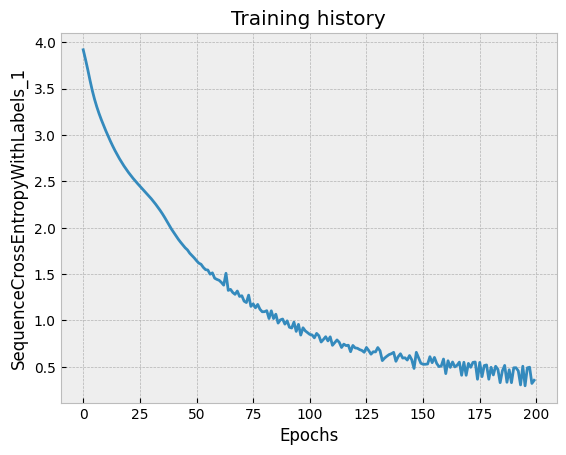

In [26]:
history = optimizer.optimize(model, X_echo, Y_echo, error)
nn.plot.plot_history(history, error_name=error.name)

In [27]:
y_pred_logits = model.forward(X_echo[:1])
y_pred_idx    = nn.utils.onehot2labels(y_pred_logits)[0]

In [28]:
X_echo[:1].shape, y_pred_logits.shape

((1, 20, 51), (1, 20, 51))

In [29]:
print("X:", np.argmax(X_echo[0], axis=1))
print("y:", np.argmax(Y_echo[0], axis=1))
print("ŷ:", np.argmax(y_pred_logits[0], axis=1))

X: [47 31  6 18 28  8 17 50 22 25 31 22 19 31 23  5 47 44 34 32]
y: [ 0  0  0 47 31  6 18 28  8 17 50 22 25 31 22 19 31 23  5 47]
ŷ: [20 28 32 47 31  6 18 28  8 17 50 22 25 31 14 19 31 23  5 47]


In [30]:
# definir estado inicial (t = -1) -> h_prev
# Forward pass a través del tiempo (for i to timesteps)
    # Calcular estado oculto: h_t = tanh(x_t @ U.T + h_prev @ W.T)
    # Calcular salida: y_t = h_t @ V.T
    # Almacenar estado y actualizar para siguiente timestep

# Backward pass a través del tiempo (en reversa)
    # # Gradiente para V: dE/dV += (dE_dy_t.T @ h_t)
    # dE_dV += np.dot(
    #     dE_dy[:, t, :].T, hs[:, t, :]  # (input_dim, batch_size)  # (batch_size, hidden_dim)
    # )  # Resultado: (input_dim, hidden_dim)

    # # Gradiente del estado oculto (desde salida y estado siguiente)
    # dE_dh = np.dot(dE_dy[:, t, :], V) + dh_next  # (batch_size, hidden_dim)  # (batch_size, hidden_dim)

    # # Gradiente a través de tanh (dhraw = dE_dh * (1 - hs[t]^2))
    # dh_raw = (1 - hs[:, t, :] ** 2) * dE_dh

    # # Gradiente para U: dE/dU += (dh_raw.T @ x_t)
    # dE_dU += np.dot(
    #     dh_raw.T, x[:, t, :]  # (hidden_dim, batch_size)  # (batch_size, input_dim)
    # )  # Resultado: (hidden_dim, input_dim)

    # # Gradiente para entrada x_t: dE/dx_t = dh_raw @ U
    # dE_dx[:, t, :] = np.dot(dh_raw, U)  # (batch_size, input_dim)

    # # Actualizar dh_next si no es el primer timestep
    # if t > 0:
    #     # Gradiente para W: dE/dW += (dh_raw.T @ h_{t-1})
    #     dE_dW += np.dot(
    #         dh_raw.T, hs[:, t - 1, :]  # (hidden_dim, batch_size)  # (batch_size, hidden_dim)
    #     )  # Resultado: (hidden_dim, hidden_dim)

    #     # Preparar gradiente para siguiente estado: dh_next = dh_raw @ W
    #     dh_next = np.dot(dh_raw, W)  # (batch_size, hidden_dim)
    # else:
    #     # En t=0 no hay estado anterior
    #     dh_next = np.zeros((batch_size, self.hidden_dim))